In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [2]:
from scipy import ndimage
from pickle import load

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # Add dimension at position 1 (depth) to be able to pass it into Conv3D which expects batch_size x channels x depth x height x width
        img_result_tensor = torch.unsqueeze(img_result_tensor, dim=1)
        
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [11]:
import torchvision
from torchvision import datasets, models, transforms

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
class Res3DNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        
        self.resnet_model = models.video.r3d_18()

        self.resnet_model.stem[0] = nn.Conv3d(150, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        
        if pretrained:
            #Download weights for resnet50
            url = "https://download.pytorch.org/models/r3d_18-b3b3357e.pth"
            state = torch.utils.model_zoo.load_url(url)
            # state_resnet = {f'resnet_model.{k}': v for k, v in state.items()}
            state_resnet = state
            # Adapt last layer (FC) to 1 class output
            state_resnet['fc.weight'] = state_resnet['fc.weight'][:1, :]
            state_resnet['fc.bias'] = state_resnet['fc.bias'][:1]
            # Adapt stem.0.weight (Conv3D) layer to 150 input channels
            conv1_weight = state_resnet['stem.0.weight']
            conv1_dtype = conv1_weight.dtype
            conv1_weight = conv1_weight.float()
            repeat = int(ceil(150 / 3))
            conv1_weight = conv1_weight.repeat(1, repeat, 1, 1, 1)[:, :150, :, :, :] # copy first 3 channels repeat-times
            conv1_weight *= (3 / float(150))
            conv1_weight = conv1_weight.to(conv1_dtype)
            state_resnet['stem.0.weight'] = conv1_weight
            

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [14]:
BATCH_SIZE = 12
EPOCHS = 300

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

In [16]:
model = Res3DNetCNN(pretrained=True)
model.to(device)

Res3DNetCNN(
  (resnet_model): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(150, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_si

### Tests and Overfitting

### Overfitting on single batch of data

In [49]:
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [68]:
train_data_single_batch = next(iter(train_dataloader))

In [69]:
train_data_single_batch['image'][0].shape

torch.Size([150, 1, 300, 300])

In [70]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 1, 300, 300])

In [75]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [76]:
output.shape

torch.Size([12, 1])

In [77]:
output

tensor([[0.5715],
        [0.3078],
        [0.3641],
        [0.4050],
        [0.3146],
        [0.5244],
        [0.3135],
        [0.3303],
        [0.3460],
        [0.5116],
        [0.3460],
        [0.6471]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [78]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-0.0204],
        [ 1.1424],
        [-0.6375],
        [-0.5256],
        [ 0.4508],
        [-0.3730],
        [ 0.4406],
        [ 0.0542],
        [ 0.0033],
        [-0.0950],
        [ 0.2440],
        [ 0.1932]], device='cuda:0', dtype=torch.float64)

In [79]:
loss_func(output, stacked_gt)

tensor(0.5251, device='cuda:0', grad_fn=<L1LossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [80]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [81]:
train_data_single_batch['sample_index']

tensor([1406,  461,  780, 1457,  437, 1228,  438, 1708,  921, 1544, 1011, 1318])

In [82]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 69.7],
       [104. ],
       [ 51.5],
       [ 54.8],
       [ 83.6],
       [ 59.3],
       [ 83.3],
       [ 71.9],
       [ 70.4],
       [ 67.5],
       [ 77.5],
       [ 76. ]])

In [83]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [84]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 69.7],
       [104. ],
       [ 51.5],
       [ 54.8],
       [ 83.6],
       [ 59.3],
       [ 83.3],
       [ 71.9],
       [ 70.4],
       [ 67.5],
       [ 77.5],
       [ 76. ]])

In [85]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [90]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = Res3DNetCNN(pretrained=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 0.42281049489974976, MSE: [0.42281047], MSE from unscaled values: [367.85767]
epoch: 10, loss: 0.9767284393310547, MSE: [0.9767285], MSE from unscaled values: [849.7829]
epoch: 20, loss: 0.25168749690055847, MSE: [0.2516875], MSE from unscaled values: [218.97559]
epoch: 30, loss: 0.13768121600151062, MSE: [0.13768122], MSE from unscaled values: [119.78674]
epoch: 40, loss: 0.06927946209907532, MSE: [0.06927945], MSE from unscaled values: [60.27518]
epoch: 50, loss: 0.044809740036726, MSE: [0.04480973], MSE from unscaled values: [38.985813]
epoch: 60, loss: 0.019443942233920097, MSE: [0.01944394], MSE from unscaled values: [16.916807]
epoch: 70, loss: 0.008407908491790295, MSE: [0.00840791], MSE from unscaled values: [7.3151336]
epoch: 80, loss: 0.011573085561394691, MSE: [0.01157308], MSE from unscaled values: [10.068933]
epoch: 90, loss: 0.004000367596745491, MSE: [0.00400037], MSE from unscaled values: [3.4804327]
epoch: 100, loss: 0.0009780051186680794, MSE: [0.00097

KeyboardInterrupt: 

### Training Definition

In [19]:
parameter = 'pH'

In [20]:
save_name = "checkpoint_state_dict_Res3DNet18_18_05_2022_Single_Parameter_Scaled_PretrainedModel_{}".format(parameter)
save_name

'checkpoint_state_dict_Res3DNet18_18_05_2022_Single_Parameter_Scaled_PretrainedModel_pH'

In [21]:
model_name = save_name+'.pth'

In [22]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [23]:
model = Res3DNetCNN(pretrained=True).to(device)

In [24]:
wandb.watch(model, log="None", log_freq=20)

[]

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [26]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [89]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [90]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [91]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.06E-01


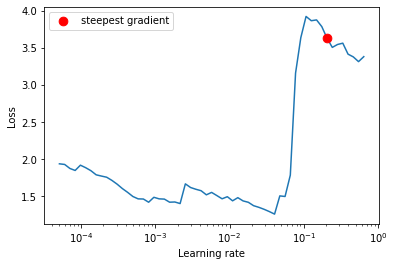

In [92]:
lr_finder.plot()
lr_finder.reset()

In [93]:
2.06E-01

0.206

### Training

In [27]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [28]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [29]:
config = wandb.config
config.model = 'ResNet3D 18 layer'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet3D 18 layer Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable. Model pretrained on KINETICS400_V1'.format(parameter)
config.parameter = parameter

In [30]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [31]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2.180542230606079, train MSE: [2.180542230606079], train MSE from unscaled values: [0.147657573223114]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 0.9404950737953186, validation MSE: [0.9404950737953186], validation MSE from unscaled values: [0.0636865571141243]
Validation loss decreased (inf --> 0.940495).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 0.9196508526802063, train MSE: [0.9196509718894958], train MSE from unscaled values: [0.062275078147649765]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 1.2300941944122314, validation MSE: [1.230094313621521], validation MSE from unscaled values: [0.08329705148935318]
EarlyStopping counter: 1 out of 13


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 0.9239451289176941, train MSE: [0.9239450693130493], train MSE from unscaled values: [0.0625658705830574]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 0.9254891276359558, validation MSE: [0.9254891872406006], validation MSE from unscaled values: [0.06267042458057404]
Validation loss decreased (0.940495 --> 0.925489).  Saving model ...


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 0.9371595978736877, train MSE: [0.9371595978736877], train MSE from unscaled values: [0.06346069276332855]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 0.9522306323051453, validation MSE: [0.9522306323051453], validation MSE from unscaled values: [0.06448124349117279]
EarlyStopping counter: 1 out of 13


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 0.9212562441825867, train MSE: [0.9212563037872314], train MSE from unscaled values: [0.062383782118558884]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 0.9280498623847961, validation MSE: [0.9280499219894409], validation MSE from unscaled values: [0.06284382194280624]
EarlyStopping counter: 2 out of 13


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 0.9220159649848938, train MSE: [0.9220160245895386], train MSE from unscaled values: [0.06243523210287094]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 1.9093934297561646, validation MSE: [1.9093936681747437], validation MSE from unscaled values: [0.12929648160934448]
EarlyStopping counter: 3 out of 13


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 0.933747410774231, train MSE: [0.9337474703788757], train MSE from unscaled values: [0.06322963535785675]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 0.9454857707023621, validation MSE: [0.9454857110977173], validation MSE from unscaled values: [0.06402450799942017]
EarlyStopping counter: 4 out of 13


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.9129167795181274, train MSE: [0.9129167795181274], train MSE from unscaled values: [0.06181906536221504]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 0.9292100667953491, validation MSE: [0.9292101263999939], validation MSE from unscaled values: [0.06292238086462021]
EarlyStopping counter: 5 out of 13


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 0.9037896990776062, train MSE: [0.9037896394729614], train MSE from unscaled values: [0.06120101362466812]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 0.9892203211784363, validation MSE: [0.9892202615737915], validation MSE from unscaled values: [0.06698604673147202]
EarlyStopping counter: 6 out of 13


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.006, train loss: 0.8907052874565125, train MSE: [0.8907053470611572], train MSE from unscaled values: [0.060315005481243134]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 0.8970881700515747, validation MSE: [0.8970882296562195], validation MSE from unscaled values: [0.060747213661670685]
Validation loss decreased (0.925489 --> 0.897088).  Saving model ...


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.006, train loss: 0.8971047401428223, train MSE: [0.8971046805381775], train MSE from unscaled values: [0.06074834242463112]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 0.939528226852417, validation MSE: [0.9395282864570618], validation MSE from unscaled values: [0.06362110376358032]
EarlyStopping counter: 1 out of 13


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.006, train loss: 0.9152135848999023, train MSE: [0.9152137041091919], train MSE from unscaled values: [0.061974599957466125]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 0.8998606204986572, validation MSE: [0.8998607397079468], validation MSE from unscaled values: [0.06093495711684227]
EarlyStopping counter: 2 out of 13


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.006, train loss: 0.8997015357017517, train MSE: [0.8997014760971069], train MSE from unscaled values: [0.06092417985200882]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.9185136556625366, validation MSE: [0.9185137152671814], validation MSE from unscaled values: [0.06219806894659996]
EarlyStopping counter: 3 out of 13


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 0.8958949446678162, train MSE: [0.8958950042724609], train MSE from unscaled values: [0.060666415840387344]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 0.9158332943916321, validation MSE: [0.9158332943916321], validation MSE from unscaled values: [0.062016561627388]
EarlyStopping counter: 4 out of 13


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 0.8924917578697205, train MSE: [0.8924918174743652], train MSE from unscaled values: [0.06043596565723419]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 0.9166811108589172, validation MSE: [0.9166811108589172], validation MSE from unscaled values: [0.062073964625597]
EarlyStopping counter: 5 out of 13


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 0.8888484239578247, train MSE: [0.8888483643531799], train MSE from unscaled values: [0.06018925830721855]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 0.9161576628684998, validation MSE: [0.9161576628684998], validation MSE from unscaled values: [0.06203852593898773]
EarlyStopping counter: 6 out of 13


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.0036, train loss: 0.882690966129303, train MSE: [0.882690966129303], train MSE from unscaled values: [0.059772297739982605]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 0.9240567088127136, validation MSE: [0.9240566492080688], validation MSE from unscaled values: [0.06257341802120209]
EarlyStopping counter: 7 out of 13


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.0036, train loss: 0.8974753618240356, train MSE: [0.8974753022193909], train MSE from unscaled values: [0.06077342852950096]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 0.9124096035957336, validation MSE: [0.9124096632003784], validation MSE from unscaled values: [0.06178472563624382]
EarlyStopping counter: 8 out of 13


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.0036, train loss: 0.8940969705581665, train MSE: [0.8940970301628113], train MSE from unscaled values: [0.060544662177562714]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 0.915322482585907, validation MSE: [0.9153225421905518], validation MSE from unscaled values: [0.06198197603225708]
EarlyStopping counter: 9 out of 13


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.0036, train loss: 0.8735893368721008, train MSE: [0.8735893964767456], train MSE from unscaled values: [0.05915598198771477]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.9058598279953003, validation MSE: [0.9058598279953003], validation MSE from unscaled values: [0.06134120002388954]
EarlyStopping counter: 10 out of 13


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.0036, train loss: 0.8682471513748169, train MSE: [0.8682471513748169], train MSE from unscaled values: [0.05879421532154083]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 0.9177342057228088, validation MSE: [0.9177342653274536], validation MSE from unscaled values: [0.062145281583070755]
EarlyStopping counter: 11 out of 13


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.0036, train loss: 0.8889111876487732, train MSE: [0.888911247253418], train MSE from unscaled values: [0.0601935088634491]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 1.2576695680618286, validation MSE: [1.2576695680618286], validation MSE from unscaled values: [0.08516433835029602]
EarlyStopping counter: 12 out of 13


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.00216, train loss: 0.8710095286369324, train MSE: [0.8710094690322876], train MSE from unscaled values: [0.0589812695980072]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.8986175656318665, validation MSE: [0.8986175656318665], validation MSE from unscaled values: [0.060850776731967926]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [32]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [33]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_Res3DNet18_18_05_2022_Single_Parameter_Scaled_PretrainedModel_pH.pth

In [34]:
# load saved model
modelLoad = Res3DNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_Res3DNet18_18_05_2022_Single_Parameter_Scaled_PretrainedModel_pH.pth')))

<All keys matched successfully>

In [35]:
modelLoad = modelLoad.to(device)